In [9]:
import matplotlib
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import rich
sns.set()
colors = sns.color_palette()
matplotlib.rcParams['figure.figsize'] = (12, 8)

from fz_openqa.datamodules.pipes.sampler import PrioritySampler



/Users/valv/Library/Caches/pypoetry/virtualenvs/fz-openqa-rEqQaPFC-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  This is separate from the ipykernel package so we can avoid doing imports until


> f.shape: torch.Size([100]), x: torch.Size([100])

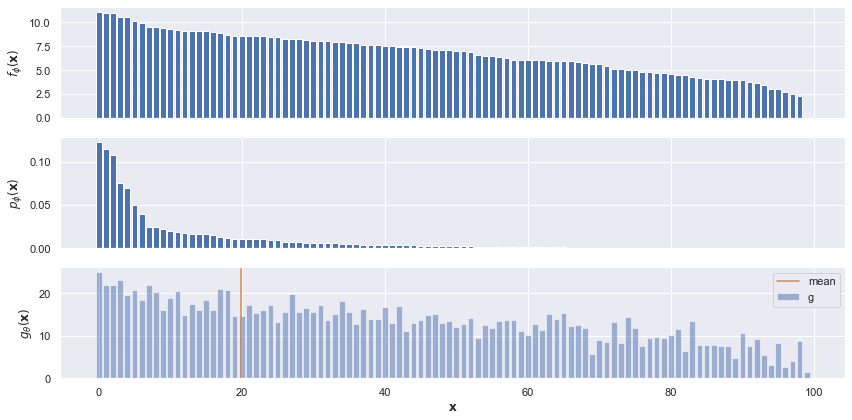

In [39]:
# base functions
n = 100
x = torch.range(0, n-1)
f =  2 *  torch.randn(n,)
f -= f.min()
g =  (2 * f + 2 *  torch.randn(n,)).abs()
f, idx =  f.sort(descending=True)
g = g[idx]
rich.print(f"> f.shape: {f.shape}, x: {x.shape}")

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 6))
axes[0].bar(x, f.numpy())
axes[0].set_ylabel(r"$f_\phi(\mathbf{x})$")
log_p = f.log_softmax(dim=-1)
axes[1].bar(x, log_p.exp().numpy(), label="p")
axes[1].set_ylabel(r"$p_\phi(\mathbf{x})$")
# axes[1].set_yscale("log")

mu = torch.sum(log_p.exp() * g)
axes[2].bar(x, g.numpy(), label="g", color=colors[0], alpha=0.5)
axes[2].axvline(mu, color=colors[1], label="mean")
axes[2].set_ylabel(r"$g_\theta(\mathbf{x})$")
axes[2].set_xlabel(r"$\mathbf{x}$")
axes[2].legend()
plt.tight_layout()
plt.show()

## Monte Carlo vs. priority sampling

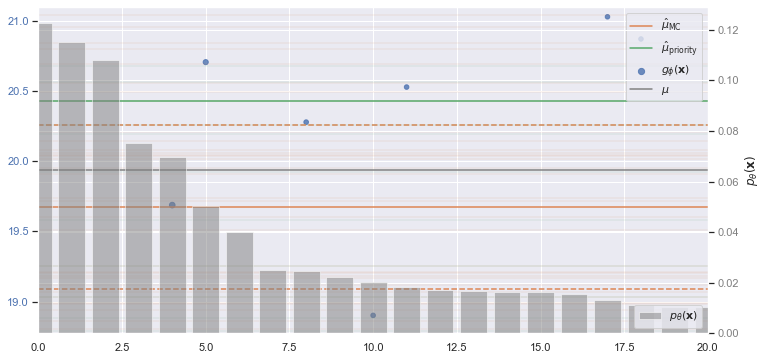

>> mu_mc_mean: 19.673559188842773, mu_priority_mean: 20.426677703857422

In [41]:
m = 10
n_samples = 50
log_p_ = log_p.view(1, -1).repeat(n_samples, 1)
g_ = g.view(1, -1).repeat(n_samples, 1)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
ax2.set_ylabel(r"$p_\theta(\mathbf{x})$")

# MC estimate
z = log_p_.exp().multinomial(m, replacement=True)
mu_mc = g_.gather(dim=1, index=z).mean(dim=1)
for mu_mc_ in mu_mc[:100]:
    ax1.axhline(mu_mc_, color=colors[1], alpha=1e-1)
mu_mc_mean = mu_mc.mean(-1)
ax1.axhline(mu_mc_mean, color=colors[1], alpha=1, label="$\hat{\mu}_{\mathrm{MC}}$")
ax1.axhline(mu_mc_mean + 0.5 * mu_mc.std(-1), color=colors[1], alpha=1, linestyle="--")
ax1.axhline(mu_mc_mean - 0.5 * mu_mc.std(-1), color=colors[1], alpha=1, linestyle="--")

# priority sampling estimate
z, log_qz = PrioritySampler.sample(log_p_, m)
mu_priority = ((log_p_.gather(dim=1, index=z) - log_qz).exp() * g_.gather(dim=1, index=z)).sum(dim=1)
for mu_priority_ in mu_priority[:100]:
    ax1.axhline(mu_priority_, color=colors[2], alpha=1e-1)
mu_priority_mean = mu_priority.mean(-1)
ax1.axhline(mu_priority_mean, color=colors[2], alpha=1, label="$\hat{\mu}_{\mathrm{priority}}$")
ax1.axhline(mu_priority_mean + 0.5 * mu_priority.std(-1), color=colors[2], alpha=1, linestyle="--")
ax1.axhline(mu_priority_mean - 0.5 * mu_priority.std(-1), color=colors[2], alpha=1, linestyle="--")

# data
ax1.scatter(x, g.numpy(), s=20 + (50 *log_p.exp().numpy())**2, label=r"$g_\phi(\mathbf{x})$", color=colors[0], alpha=0.8)
ax2.bar(x, log_p.exp().numpy(), label=r"$p_\theta(\mathbf{x})$", color="gray", alpha=0.5)
ax1.axhline(mu, color="gray", label="$\mu$")
ax1.legend(loc="upper right", )
ax2.legend(loc="lower right")
ax1.tick_params(axis="y", labelcolor=colors[0])
ax2.tick_params(axis="y", labelcolor="gray")
plt.xlim(0, 20)
ax1.set_ylim(mu - mu_mc.std(-1), mu + mu_mc.std(-1))
plt.show()
rich.print(f">> mu_mc_mean: {mu_mc_mean}, mu_priority_mean: {mu_priority_mean}")

### Convergence

> log_p: torch.Size([100]), g: torch.Size([100])

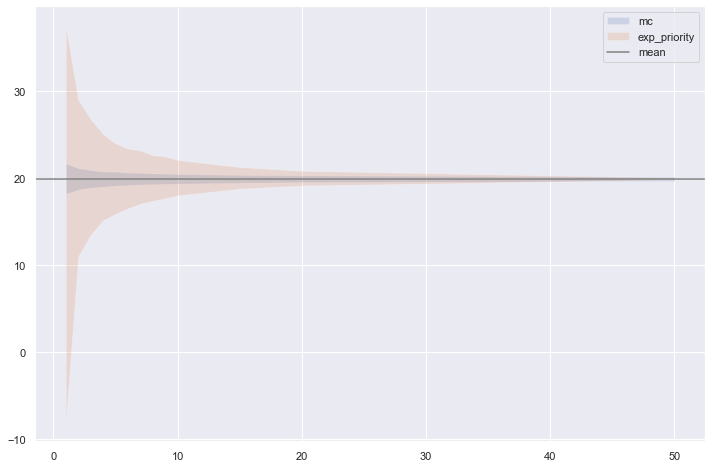

In [45]:

from typing import Tuple


def priority_sample(
    logits: torch.Tensor,
        m: int,
        largest: bool = False,
        mode: str = "uniform",
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Sample `log p(z)` using priority sampling with subset of size `m`

    Args:
        logits (torch.Tensor): un-normalized logits of the distribution
        m (int): size of the subset to sample

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: sampled index and log probs
    """
    assert mode in {"uniform", "exponential"}
    log_pz = logits.log_softmax(dim=-1)
    if mode == "uniform":
        if largest:
            u = 0.5 * torch.ones_like(log_pz)
        else:
            u = torch.rand_like(log_pz)
    elif mode == "exponential":
        if largest:
            u = torch.ones_like(log_pz)
        else:
            u = torch.empty_like(log_pz)
            u.exponential_()
    else:
        raise ValueError(f"Unknown mode {mode}")

    log_u = u.log()
    keys = log_pz - log_u
    z = keys.argsort(dim=-1, descending=True)[..., : m + 1]
    z_tau = z[..., -1:]
    log_tau = keys.gather(-1, index=z_tau)[..., :1]
    z = z[..., :m]
    log_pz = log_pz.gather(dim=-1, index=z)
    if mode == "uniform":
        log_pz = torch.where(log_pz - log_tau < 0, log_pz - log_tau, torch.zeros_like(log_pz))
    elif mode =="exponential":
        log_pz = (-1* (log_pz - log_tau).exp()).exp().mul(-1).log1p()
    else:
        raise ValueError(f"Unknown mode {mode}")
    return z, log_pz

from collections import defaultdict

rich.print(f"> log_p: {log_p.shape}, g: {g.shape}")
mu = torch.sum(log_p.exp() * g)
n_samples = 10000
log_p_ = log_p.view(1, -1).repeat(n_samples, 1)
g_ = g.view(1, -1).repeat(n_samples, 1)
f_ = f.view(1, -1).repeat(n_samples, 1)

data = defaultdict(list)
for m in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,15, 20, 50]:
    data['m'] += [m]
    z = log_p_.exp().multinomial(m, replacement=True)
    mu_mc = g_.gather(dim=-1, index=z).mean(dim=1)
    mu_mc_upper = mu_mc.mean(dim=-1) + 0.5 * mu_mc.std(-1)
    mu_mc_lower = mu_mc.mean(dim=-1) - 0.5 * mu_mc.std(-1)
    data['mc_upper'] += [mu_mc_upper.item()]
    data['mc_lower'] += [mu_mc_lower.item()]

    z = log_p_.exp().multinomial(m, replacement=False)
    mu_mc = g_.gather(dim=1, index=z).mean(dim=1)
    mu_mc_upper = mu_mc.mean(dim=-1) + 0.5 * mu_mc.std(-1)
    mu_mc_lower = mu_mc.mean(dim=-1) - 0.5 * mu_mc.std(-1)
    data['mc_rpl_upper'] += [mu_mc_upper.item()]
    data['mc_rpl_lower'] += [mu_mc_lower.item()]

    z, log_qz = priority_sample(log_p_, m, mode="uniform")
    mu_priority = ((log_p_.gather(dim=1, index=z) - log_qz).exp() * g_.gather(dim=1, index=z)).sum(dim=1)
    mu_priority_upper = mu_priority.mean(dim=-1) + 0.5 * mu_priority.std(-1)
    mu_priority_lower = mu_priority.mean(dim=-1) - 0.5 * mu_priority.std(-1)
    data['priority_upper'] += [mu_priority_upper.item()]
    data['priority_lower'] += [mu_priority_lower.item()]

    z, log_qz = priority_sample(log_p_, m, mode="exponential")
    mu_priority = ((log_p_.gather(dim=1, index=z) - log_qz).exp() * g_.gather(dim=1, index=z)).sum(dim=1)
    mu_priority_upper = mu_priority.mean(dim=-1) + 0.5 * mu_priority.std(-1)
    mu_priority_lower = mu_priority.mean(dim=-1) - 0.5 * mu_priority.std(-1)
    data['exp_priority_upper'] += [mu_priority_upper.item()]
    data['exp_priority_lower'] += [mu_priority_lower.item()]


plt.fill_between(data['m'], data['mc_lower'], data['mc_upper'], label='mc', alpha=0.2)
# plt.fill_between(data['m'], data['mc_rpl_lower'], data['mc_rpl_upper'], label='mc-swor', alpha=0.2)
# plt.fill_between(data['m'], data['priority_lower'], data['priority_upper'], label='priority', alpha=0.2)
plt.fill_between(data['m'], data['priority_lower'], data['exp_priority_upper'], label='exp_priority', alpha=0.2)
plt.axhline(mu, label="mean", color="gray")
plt.legend()
# plt.ylim(mu - 1, mu + 1)
plt.show()



### Importance Sampling with priority proposal

/Users/valv/Library/Caches/pypoetry/virtualenvs/fz-openqa-rEqQaPFC-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  """


tensor(1.8368)

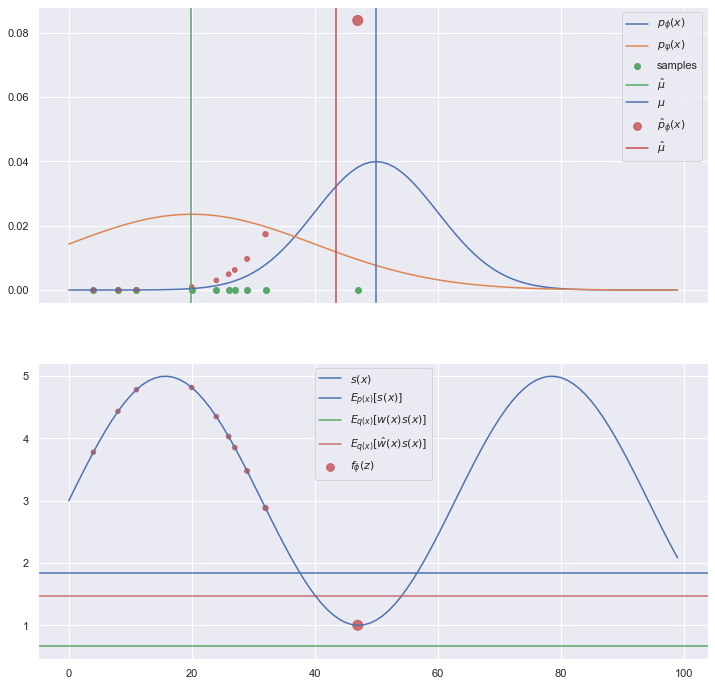

In [44]:
from pytorch_lightning import seed_everything

# seed_everything(13)
n = 100
x = torch.range(0, n-1)
f_psi =  torch.distributions.Normal(20, 20).log_prob(x.float()) + 1000
f_phi =  torch.distributions.Normal(50, 10).log_prob(x.float()) - 1000
logp_phi = f_phi.log_softmax(0)
logp_psi = f_psi.log_softmax(0)
mu = (x * logp_phi.exp()).sum()

m = 10
z, log_q_psi = priority_sample(logp_psi,
                               m,
                               largest=False,
                               mode="exponential")
log_w = logp_phi[z] - log_q_psi
mu_hat = (log_w.exp() * x[z]).sum()

fig, axes=plt.subplots(2, 1, sharex=True, figsize=(12, 12))

# density plot
axes[0].plot(x, logp_phi.exp(), color=colors[0], label="$p_\phi(x)$")
axes[0].plot(x, logp_psi.exp(),color=colors[1], label="$p_\psi(x)$")
axes[0].scatter(z, torch.zeros_like(z), color=colors[2], label="samples")
axes[0].axvline(mu_hat, color=colors[2], label="$\hat{\mu}}$")
axes[0].axvline(mu, color=colors[0], label="$\mu$")

# score space
score = lambda x: 2* (x/10).sin() + 3
f_mean = (score(x) * logp_phi.exp()).sum()
f_hat = (log_w.exp() * score(x[z])).sum()
rich.print(f_mean)
axes[1].plot(x, score(x), color=colors[0], label="$s(x)$")
# axes[1].scatter(z, score(z), color=colors[2], label="samples")
axes[1].axhline(f_mean, color=colors[0], label="$E_{p(x)} [s(x)]$")
axes[1].axhline(f_hat, color=colors[2], label="$E_{q(x)} [w(x) s(x)]$")



# estimate p_phi(x)
f_psi = f_psi - 0 #f_psi.max(dim=-1, keepdim=True).values
log_Z_psi = f_psi.logsumexp(dim=-1, keepdim=True)

# sample values
f_psi_z = f_psi[z]
f_phi_z = f_phi[z]
log_q_psi_z = log_q_psi

# normalize
M_psi = f_psi_z.max(dim=-1).values
M_phi = f_phi_z.max(dim=-1).values
f_phi_z = f_phi_z - M_phi + M_psi
# compute variables
log_zeta_z = f_phi_z - f_psi_z
logp_psi_z = f_psi_z - log_Z_psi
log_Z_phi_hat = log_Z_psi + (logp_psi_z - log_q_psi_z + log_zeta_z).logsumexp(dim=-1, keepdim=True)
log_p_phi_hat = f_phi_z - log_Z_phi_hat
w_hat = (log_p_phi_hat - log_q_psi).exp()
# plot
axes[0].scatter(z, log_p_phi_hat.exp(), color=colors[3], label="$\hat{p}_\phi(x)$", alpha=0.8, s=20+100*w_hat)
mu_hat_hat = (w_hat * x[z]).sum()
axes[0].axvline(mu_hat_hat, color=colors[3], label="$\hat{\mu}}'$")
f_hat_hat = (w_hat * score(x[z])).sum()
axes[1].axhline(f_hat_hat, color=colors[3],
                label="$E_{q(x)} [\hat{w}(x) s(x)]$", alpha=0.8)
axes[1].scatter(z, score(x[z]), color=colors[3], label="$f_\phi(z)$", alpha=0.8, s=20+100*w_hat)


# estimate p_phi without fancy approximation
SIMPLE_ESTIMATE = False
if SIMPLE_ESTIMATE:
    p_phi_hat_simple = f_phi[z].exp() / f_phi[z].exp().sum()
    axes[0].scatter(z, p_phi_hat_simple, color=colors[4], label="$\hat{p}_\phi(x)''$", alpha=0.8)
    w_hat_simple = p_phi_hat_simple / log_q_psi.exp()
    mu_hat_simple = (w_hat_simple * x[z]).sum()
    axes[0].axvline(mu_hat_simple, color=colors[4], label="$\hat{\mu}}''$")
    f_hat_simple = (w_hat_simple * score(x[z])).sum()
    axes[1].axhline(f_hat_simple, color=colors[4],
                    label="$E_{q(x)} [\hat{w}(x)'' s(x)]$", alpha=0.8)


axes[0].legend()
axes[1].legend()
plt.show()

## Notebook from Graduate Descent - Tim Vieira

### Priority Sampling vs. Monte Carlo

In [6]:


import numpy as np
import pylab as pl
from tqdm import tqdm
from collections import defaultdict
from numpy.linalg import norm

def spherical(size):
    "Generate random vector from spherical Gaussian."
    x = np.random.normal(0, 1, size=size)
    x /= norm(x, 2)
    return x

n = 50        # dimensionality
R = 1000    # replications

# probability vector
p = np.random.dirichlet(np.ones(n))

# random function.
f = spherical(n)

U = range(n)
true = p.dot(f)

data = defaultdict(lambda: np.zeros((R, n)))
for z in tqdm(range(R)):

    # Monte Carlo
    s = np.random.choice(U, size=n, p=p, replace=1)   # sample n elements up front
    r = np.cumsum(f[s]) / (1+np.arange(n))            # running average gives each k<=n
    data['mc'][z] = r

    # Priority sampling
    u = np.random.uniform(0,1,size=n)
    key = u / p                                       # ~ Uniform(0, p[i])
    order = np.argsort(key)                           # smallest first
    sortd = key[order]                                # sample up front (for efficiency)
    r = np.zeros(n)
    for k in range(1, n+1):                           # report what we would have gotten for each k<=n
        t = sortd[k] if k < n else np.inf             # threshold is the (k+1)th element
        S = order[:k]                                 # sample is the set of k smallest priorities
        #q = np.minimum(1, t*p)                       # = p(i in S | t)
        r[k-1] = f[S].dot(np.maximum(p[S], 1/t))      # = f[S].dot(p[S]/q[S])
    data['ps'][z] = r

    # PPSWOR
    key = -np.log(u) / p                              # ~ Exp(p[i])
    order = np.argsort(key)
    sortd = key[order]
    r = np.zeros(n)
    for k in range(1, n+1):
        t = sortd[k] if k < n else np.inf
        S = order[:k]
        q = 1 - np.exp(-p*t)                          # = p(i in S | t)
        r[k-1] = f[S].dot(p[S]/q[S])
    data['ppswor'][z] = r

    # custom priority_sample
    r = np.zeros(n)
    for m in range(0, n):
        log_p = torch.from_numpy(p).log()
        S, log_q = priority_sample(log_p, m)
        q = log_q.exp().numpy()
        S = S.numpy()
        r[m] = f[S].dot(p[S]/q)

    data['ps-custom'][z] = r


100%|██████████| 1000/1000 [00:04<00:00, 222.08it/s]


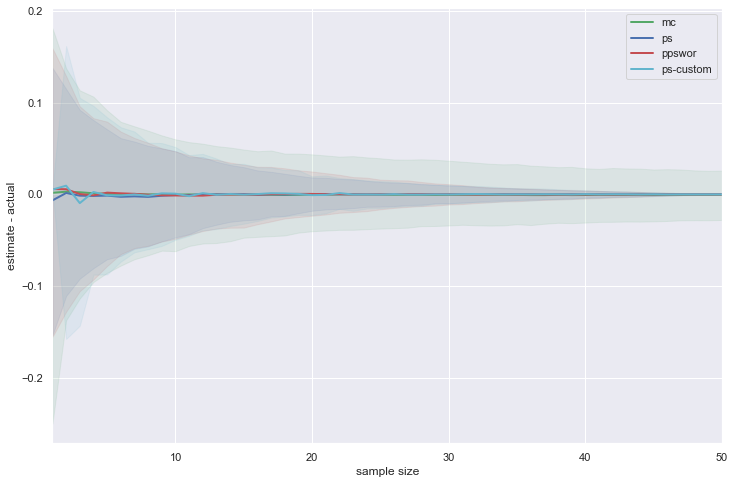

In [19]:
_colors = {
    'mc': 'g',
    'ps': 'b',
    'ppswor': 'r',
    'ps-custom': 'c',
}

ax = pl.figure().add_subplot(111)
xs = range(1, n+1)
for name, runs in data.items():
    c = _colors[name]
    if not len(runs):
        continue
    runs = np.array(runs) - true
    ax.plot(xs, runs.mean(axis=0), c=c, lw=2, label=name)
    # Show error bars
    delta = 0.1
    ax.fill_between(xs,
                    np.percentile(runs, 100*delta, axis=0),
                    np.percentile(runs, 100*(1-delta), axis=0),
                    color=c, alpha=0.1)

ax.grid(True)
pl.xlim(1, n)
pl.xlabel('sample size')
pl.ylabel('estimate - actual')
pl.legend(loc='best')
pl.show()